In [150]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
import pmdarima as pm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

def connect_sqlserver(server='deti-sql-aulas.ua.pt',database='sisqualFORECASTDATA',username='sisqual',password='rh4.0'):
    con = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = con.cursor()

    return con,cursor
con,cursor=connect_sqlserver()

tiendas_query=cursor.execute('SELECT Distinct tienda from Martim.ForecastData;')
tiendas=[item[0] for item in tiendas_query]

In [151]:
query='SELECT*FROM [sisqualFORECASTDATA].[Martim].[ForecastData] Where tienda=?;'
data=pd.read_sql(query,con,params=[37])
data['fechaHoraInicio']=pd.to_datetime(data['fechaHoraInicio'])
data['fechaHoraFim']=pd.to_datetime(data['fechaHoraFim'])
data['fecha']=pd.to_datetime(data['fecha'])
data['cantidad']=data['cantidad'].astype(float)
data['numero']=data['numero'].astype(float)
data['tickets']=data['tickets'].astype(float)
data['importe']=data['importe'].astype(float)
data['caja']=data['caja'].astype(int)
data.where(data['tickets']<0,0)

,tienda,caja,fecha,fechaHoraInicio,fechaHoraFim,cantidad,numero,tickets,importe
0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
421402,0,0,0,0,0,0.0,0.0,0.0,0.0
421403,0,0,0,0,0,0.0,0.0,0.0,0.0
421404,0,0,0,0,0,0.0,0.0,0.0,0.0
421405,0,0,0,0,0,0.0,0.0,0.0,0.0


In [152]:
caixas=data['caja'].unique()
df=[]
for i in range(len(caixas)):
    df_=data.loc[data['caja']==caixas[i]]
    df.append(pd.DataFrame(df_.resample('H', on='fechaHoraInicio').tickets.sum()))
    df[i].reset_index(inplace=True)
forecast_data=pd.concat(df).groupby(['fechaHoraInicio']).sum().reset_index()

In [153]:
print(forecast_data.dtypes)

fechaHoraInicio    datetime64[ns]
tickets                   float64
dtype: object


In [154]:
forecast_data['Mês']=forecast_data['fechaHoraInicio'].apply(lambda x: x.month)
forecast_data['Dia']=forecast_data['fechaHoraInicio'].apply(lambda x: x.weekday())
forecast_data['Hora']=forecast_data['fechaHoraInicio'].apply(lambda x: x.hour)
inicio_2020=datetime.datetime(2020, 1, 1)
forecast_data=forecast_data[forecast_data['fechaHoraInicio']<inicio_2020]
forecast_data

,fechaHoraInicio,tickets,Mês,Dia,Hora
0,2015-01-02 10:00:00,199.0,1,4,10
1,2015-01-02 11:00:00,268.0,1,4,11
2,2015-01-02 12:00:00,337.0,1,4,12
3,2015-01-02 13:00:00,390.0,1,4,13
4,2015-01-02 14:00:00,249.0,1,4,14
...,...,...,...,...,...
43785,2019-12-31 19:00:00,146.0,12,1,19
43786,2019-12-31 20:00:00,0.0,12,1,20
43787,2019-12-31 21:00:00,0.0,12,1,21
43788,2019-12-31 22:00:00,0.0,12,1,22


In [155]:
tickets=np.array(forecast_data['tickets'])

def to_supervised(a,n_lags,n_output=1):
    X,y=[],[]
    
    for i in range(len(a)-n_lags):
        aux=[]
        for j in range(i,i+n_lags,1):
            aux.append(a[j])
        if i+n_lags+n_output<len(a):
            X.append(aux)
            y.append(a[i+n_lags:i+n_lags+n_output])

    return np.array(X),np.array(y)

X,y=to_supervised(tickets,5)
    

In [156]:
df=pd.DataFrame(np.hstack((X,y)),columns=['lag'+str(i-1) for i in range(6,0,-1)])
df=df.rename(columns={'lag0':'target'})
df

,lag5,lag4,lag3,lag2,lag1,target
0,199.0,268.0,337.0,390.0,249.0,109.0
1,268.0,337.0,390.0,249.0,109.0,86.0
2,337.0,390.0,249.0,109.0,86.0,104.0
3,390.0,249.0,109.0,86.0,104.0,142.0
4,249.0,109.0,86.0,104.0,142.0,171.0
...,...,...,...,...,...,...
43779,435.0,311.0,162.0,157.0,152.0,226.0
43780,311.0,162.0,157.0,152.0,226.0,146.0
43781,162.0,157.0,152.0,226.0,146.0,0.0
43782,157.0,152.0,226.0,146.0,0.0,0.0


In [157]:
forecast_data_final=pd.concat([forecast_data.iloc[5:,:].reset_index(drop=True),df],axis=1,join="inner")
forecast_data_final=forecast_data_final.drop(columns=['fechaHoraInicio','tickets'])
forecast_data_final

,Mês,Dia,Hora,lag5,lag4,lag3,lag2,lag1,target
0,1,4,15,199.0,268.0,337.0,390.0,249.0,109.0
1,1,4,16,268.0,337.0,390.0,249.0,109.0,86.0
2,1,4,17,337.0,390.0,249.0,109.0,86.0,104.0
3,1,4,18,390.0,249.0,109.0,86.0,104.0,142.0
4,1,4,19,249.0,109.0,86.0,104.0,142.0,171.0
...,...,...,...,...,...,...,...,...,...
43779,12,1,18,435.0,311.0,162.0,157.0,152.0,226.0
43780,12,1,19,311.0,162.0,157.0,152.0,226.0,146.0
43781,12,1,20,162.0,157.0,152.0,226.0,146.0,0.0
43782,12,1,21,157.0,152.0,226.0,146.0,0.0,0.0


In [158]:
forecast_data_final.dtypes

Mês         int64
Dia         int64
Hora        int64
lag5      float64
lag4      float64
lag3      float64
lag2      float64
lag1      float64
target    float64
dtype: object

In [159]:
X=forecast_data_final.iloc[:,:-1].values
y=forecast_data_final.iloc[:,-1].values
X_train=X[:-1440,:]
y_train=y[:-1440]
X_test=X[-1440:,:]
y_test=y[-1440:]
param_grid={'learning_rate':Continuous(0,0.5),'n_estimators':Integer(100,2000),'subsample':Continuous(0,1),'min_samples_split':Integer(2,10),'max_depth':Integer(2,10),
'min_impurity_decrease':Continuous(0,1000),'max_features':Categorical(['auto', 'sqrt', 'log2'])}
param_grid={'learning_rate':Continuous(0,0.5),'n_estimators':Integer(100,2000)}
cv = TimeSeriesSplit(n_splits=10)
reg = GradientBoostingRegressor(random_state=0)

In [160]:
reg_GA = GASearchCV(estimator=reg,
                                    cv=cv,
                                    scoring='r2',
                                    population_size=30,
                                    generations=10,
                                    tournament_size=2,
                                    elitism=True,
                                    crossover_probability=0.8,
                                    mutation_probability=0.1,
                                    param_grid=param_grid,
                                    criteria='max',
                                    algorithm='eaMuPlusLambda',
                                    n_jobs=-1,
                                    verbose=True,
                                    keep_top_k=4)

In [161]:
def train_predict(model,X_train,y_train,X_test,steps):
    model.fit(X_train,y_train)
    forecast=[]
    for k in range(len(y_test)):
        X_input=list(X_test[k,:3])
        for i in range(steps):
            if(k+i<steps):
                X_input.append(X_train[-1][k+i])
            else:
                X_input.append(forecast[-(steps-k-i)])
        forecast.append(round(max(model.predict(np.array(X_input).reshape((1,len(X_input))))[0],0)))
        #print(X_input)
    return forecast

forecast=train_predict(reg,X_train,y_train,X_test,5)

In [162]:
df_plot=pd.DataFrame.from_dict({'x':[i for i in range(len(forecast))],'Previsão':forecast,'Real':y_test})
df_plot.columns

Index(['x', 'Previsão', 'Real'], dtype='object')

In [163]:
fig = px.line(df_plot,x=df_plot['x'],y=df_plot.columns[1:],title='Previsões loja 37',                 labels={
                     "x": "Hora",
                     "value": "#tickets"
                 })
fig.show()

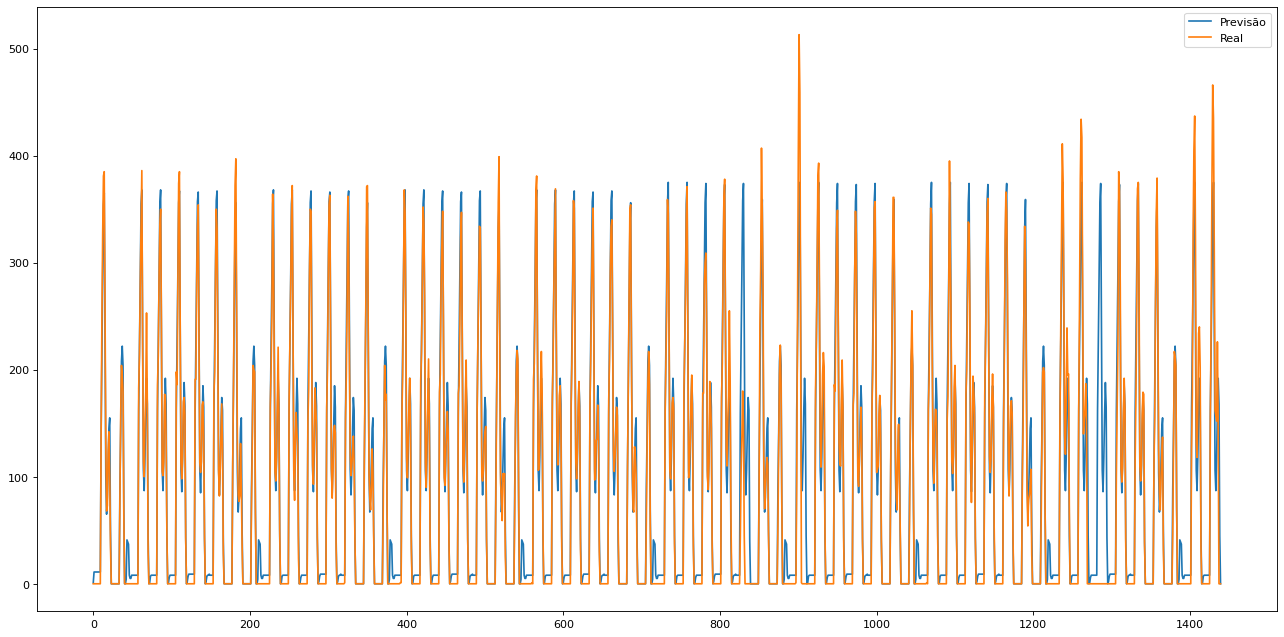

In [164]:
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(forecast)
plt.plot(y_test)
plt.legend(["Previsão", "Real"])

In [165]:
print(r2_score(y_test,forecast), mean_squared_error(y_test,forecast))

0.9149976698186552 1115.2506944444444


In [273]:
def maape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.arctan(np.abs((y_true-y_pred)/y_true)))


In [147]:
Y=forecast_data['tickets'].values
Y_train=Y[:-1440]
Y_test=Y[-1440:]


C:\Users\quilo\.conda\envs\DataScience\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



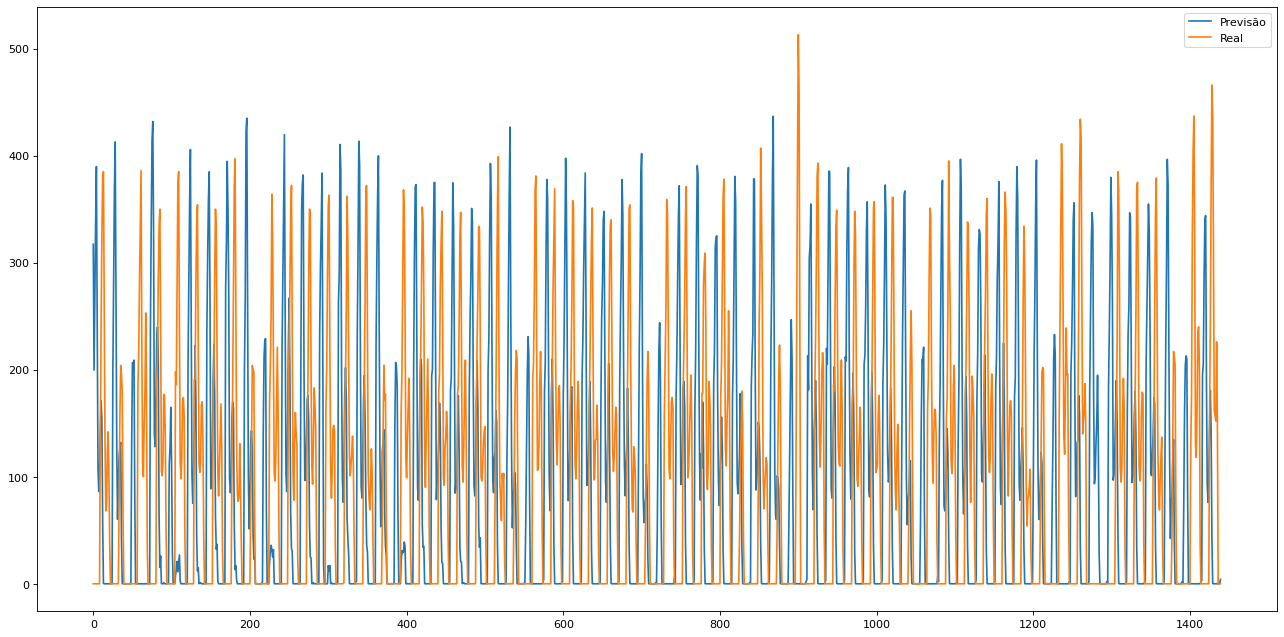

In [168]:
plt.figure(figsize=(20, 10), dpi=80)
model=ExponentialSmoothing(Y_train,seasonal_periods=7*24).fit()
pred=model.predict(start=0,end=1440-1)
plt.plot(pred)
plt.plot(Y_test)
plt.legend(["Previsão", "Real"])

In [169]:
print(r2_score(Y_test,pred), mean_squared_error(Y_test,pred))

-1.6669084676534678 34990.47042857482
